In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree, svm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import tensorflow_docs as tfdocs
from scipy import interpolate, stats
import tensorflow_docs.modeling
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

import tensorflow_docs.plots


In [2]:
def SetPlotStyle():
   plt.rcParams['axes.linewidth']  = 1.5
   plt.rcParams['axes.labelsize']  = 28
   plt.rcParams['axes.titlesize']  = 22
   plt.rcParams['xtick.labelsize'] = 20
   plt.rcParams['ytick.labelsize'] = 18
   plt.rcParams['xtick.major.size'] = 7
   plt.rcParams['ytick.major.size'] = 7
   plt.rcParams['xtick.minor.size'] = 3
   plt.rcParams['ytick.minor.size'] = 3
   plt.rcParams['legend.fontsize']  = 20
   plt.rcParams['legend.frameon']  = False

   plt.rcParams['xtick.major.width'] = 1
   plt.rcParams['ytick.major.width'] = 1
   plt.rcParams['xtick.minor.width'] = 1
   plt.rcParams['ytick.minor.width'] = 1
   plt.rcParams["font.family"] = "serif" 
   # plt.clf()
   # sns.set(rc('font',**{'family':'serif','serif':['Computer Modern']}))
   # sns.set_style("ticks", {'figure.facecolor': 'grey'})

SetPlotStyle()


In [3]:
data = pd.read_csv('/media/bita/disco/Pesquisa/ACT_PS/act_pointing_correction_codes/organized_tests/act_boresight/pointing_corr_arr4_f150_snrT25_obs2_FullSeason_withEverything.csv')
data.keys() 

data.drop(['Freq','Offset X','Elevation 2 hr ago','Azimuth 2 hr ago','Error Offset X','Array','Modulus Offset','Azimuth','Elevation','T_Pan_R8_6','T_Pan_R8_3','T_Pan_R7_8','T_Pan_R7_5','T_Pan_R7_3','T_Pan_R6_6','T_Pan_R6_3','T_Pan_R5_5Lo','T_Pan_R5_5Hi','T_Pan_R4_6','T_Pan_R4_3','T_Pan_R3_7','T_Pan_R3_5','T_Pan_R1_2','T_Pan_R2_2','T_Pan_R2_6','T_Pan_R3_1','T_Pan_R5_9'], axis=1, inplace=True)


data['Ctime']= (data['Ctime']-1514764800)/(60*60*24) #Converting ctime in days
data_time_all = data['Ctime'] #Save the time for later
data.pop('Ctime')

dy_all_data = data['Error Offset Y'] #Save this variable for later
data.pop('Error Offset Y')

data.tail()


,Offset Y,APEX T,APEX T 2 hr ago,Angular Distance 2 hr ago,Azimuth Sun 2 hr ago,Elevation Sun 2 hr ago,Elevation Sun,Azimuth Sun,Angular Distance
1467,0.1211,-0.954545,-0.918182,1.923560,2.481119,-0.587254,-0.226373,2.131115,1.446979
1468,-0.0695,-0.890909,-0.781818,1.789974,2.363467,-0.498916,-0.110557,2.062898,1.318067
1469,1.2048,4.136364,-0.400000,1.211229,2.011777,-0.009253,0.442908,1.841349,0.847712
1470,0.6847,7.127273,5.254545,0.764476,1.807493,0.557289,1.031679,1.687267,1.344860
1471,0.6625,7.227273,5.618182,0.711483,1.785118,0.637678,1.113681,1.668580,1.267329


In [4]:
#Split the data into training set and testing set:
train_dataset = data.sample(frac=0.75,random_state=1)
test_dataset = data.drop(train_dataset.index)

train_stats = train_dataset.describe() #statistics of the training set 
train_stats.pop("Offset Y") #remove the offset y of the train_dataset - I'll call offset y in the 'labels' variable
train_stats = train_stats.transpose()
train_stats

#Offset to compare:
 
train_labels = train_dataset.pop('Offset Y') #Used to train the machine learning
test_labels = test_dataset.pop('Offset Y') #Used to test the quality of the regression

#normalize the data - this is  very import to optimize the learning!
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [6]:
#Check the statistics for the training set:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
APEX T,1104.0,-3.962963,3.690192,-14.045455,-6.690909,-3.704545,-1.163636,6.163636
APEX T 2 hr ago,1104.0,-4.015468,3.877802,-13.872727,-7.000000,-3.650000,-1.104545,6.763636
Angular Distance 2 hr ago,1104.0,1.894564,0.649892,0.196311,1.508544,1.988856,2.322016,3.102921
Azimuth Sun 2 hr ago,1104.0,3.089383,1.175279,0.023656,1.965062,3.129249,4.228080,5.872375
Elevation Sun 2 hr ago,1104.0,-0.346638,0.561564,-1.234156,-0.783791,-0.428616,0.035226,1.365305
Elevation Sun,1104.0,-0.277776,0.623659,-1.238255,-0.788452,-0.397573,0.188470,1.518137
Azimuth Sun,1104.0,2.715072,1.154719,0.054734,1.761525,2.353654,3.817545,5.974902
Angular Distance,1104.0,1.876738,0.584513,0.223998,1.623696,1.940197,2.250971,3.060409


# Decision Tree method:

In [8]:
classifier = tree.DecisionTreeRegressor(random_state = 0) #This use MAE as the criterium -->  default! 
classifier.fit(normed_train_data,train_labels )
predict_dt = classifier.predict(normed_test_data)

 
err = np.float64(test_labels) -predict_dt
print(np.mean(np.abs(err)), np.std(err)) 

#Using another criterion for classify the tree, example: 
#MSE
classifier_mse = tree.DecisionTreeRegressor(criterion='mse',  max_depth=10)
classifier_mse.fit(normed_train_data,train_labels )
predict_dt_mse = classifier_mse.predict(normed_test_data)


err_mse = np.float64(test_labels) -predict_dt_mse
print(np.mean(np.abs(err_mse)), np.std(err_mse),'MAE DT, std DT') 
#In addition,I tested all the possitibilities for the criterium and changed several options for the depth and the random state
 

0.1794921195652174 0.26675635311775286
0.18662077228134547 0.27886927149953095 MAE DT, std DT


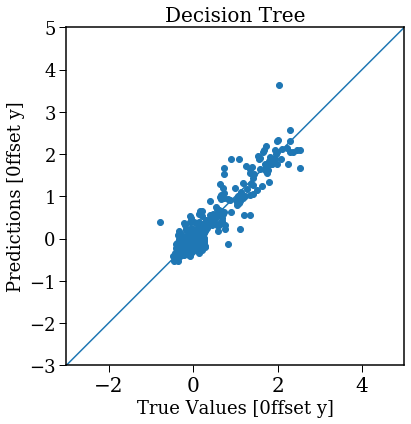

In [20]:
plt.figure(figsize=(8,6))
a = plt.axes(aspect='equal')
# plt.scatter(test_labels,predict_svr_lin, label='Poly')
plt.scatter(test_labels,predict_dt, label='RBF')

plt.xlabel('True Values [0ffset y]',fontsize=18)
plt.title('Decision Tree', fontsize=20)
plt.ylabel('Predictions [0ffset y]',fontsize=18)
lims = [-3, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.tight_layout()
 

# Support Vector regression:

In [21]:
classifier_svr = svm.SVR() #rbf kernel- uses the  gradient descent to find the best fit
classifier_svr.fit(normed_train_data,train_labels )
predict_svr = classifier_svr.predict(normed_test_data)

err_svr = np.float64(test_labels) -predict_svr
print(np.mean(np.abs(err_svr)), np.std(err_svr)) 

#Testing others kernels:
classifier_svr_lin = svm.SVR(kernel= 'poly', degree=1,gamma='auto') #linear kernel- uses the  gradient descent to find the best fitting line
classifier_svr_lin.fit(normed_train_data,train_labels )
predict_svr_lin = classifier_svr_lin.predict(normed_test_data)

err_svr_lin = np.float64(test_labels) -predict_svr_lin
print(np.mean(np.abs(err_svr_lin)), np.std(err_svr_lin)) 


0.21469602341735114 0.31776472992865806
0.3549338860387291 0.4628271555159015


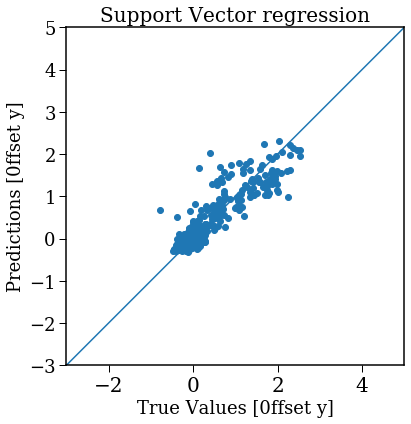

In [22]:
plt.figure(figsize=(8,6))
a = plt.axes(aspect='equal')
# plt.scatter(test_labels,predict_svr_lin, label='Poly')
plt.scatter(test_labels,predict_svr, label='RBF')

plt.xlabel('True Values [0ffset y]',fontsize=18)
plt.title('Support Vector regression', fontsize=20)
plt.ylabel('Predictions [0ffset y]',fontsize=18)
lims = [-3, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.tight_layout()
 

# Neural Network:

In [23]:
#Sequential models: 
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.00001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
 

In [24]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [25]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.27158207],
       [0.22061843],
       [0.29549104],
       [0.31808126],
       [0.21377018],
       [0.11392211],
       [0.19216436],
       [0.21385324],
       [0.08408253],
       [0.12105948]], dtype=float32)

In [28]:
EPOCHS = 20000 #number of interactions for training the network

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.4600,  mae:0.4848,  mse:0.4600,  val_loss:0.4698,  val_mae:0.4769,  val_mse:0.4698,  
....................................................................................................
Epoch: 100, loss:0.1631,  mae:0.2907,  mse:0.1631,  val_loss:0.1782,  val_mae:0.3236,  val_mse:0.1782,  
....................................................................................................
Epoch: 200, loss:0.1421,  mae:0.2657,  mse:0.1421,  val_loss:0.1546,  val_mae:0.2956,  val_mse:0.1546,  
....................................................................................................
Epoch: 300, loss:0.1311,  mae:0.2516,  mse:0.1311,  val_loss:0.1416,  val_mae:0.2783,  val_mse:0.1416,  
....................................................................................................
Epoch: 400, loss:0.1236,  mae:0.2419,  mse:0.1236,  val_loss:0.1330,  val_mae:0.2668,  val_mse:0.1330,  
........................................................................

....................................................................................................
Epoch: 4000, loss:0.0387,  mae:0.1287,  mse:0.0387,  val_loss:0.0608,  val_mae:0.1769,  val_mse:0.0608,  
....................................................................................................
Epoch: 4100, loss:0.0377,  mae:0.1272,  mse:0.0377,  val_loss:0.0599,  val_mae:0.1755,  val_mse:0.0599,  
....................................................................................................
Epoch: 4200, loss:0.0368,  mae:0.1256,  mse:0.0368,  val_loss:0.0593,  val_mae:0.1748,  val_mse:0.0593,  
....................................................................................................
Epoch: 4300, loss:0.0359,  mae:0.1240,  mse:0.0359,  val_loss:0.0588,  val_mae:0.1742,  val_mse:0.0588,  
....................................................................................................
Epoch: 4400, loss:0.0351,  mae:0.1226,  mse:0.0351,  val_loss:0.0580,  

....................................................................................................
Epoch: 8000, loss:0.0201,  mae:0.0926,  mse:0.0201,  val_loss:0.0477,  val_mae:0.1571,  val_mse:0.0477,  
....................................................................................................
Epoch: 8100, loss:0.0199,  mae:0.0921,  mse:0.0199,  val_loss:0.0478,  val_mae:0.1572,  val_mse:0.0478,  
....................................................................................................
Epoch: 8200, loss:0.0197,  mae:0.0918,  mse:0.0197,  val_loss:0.0474,  val_mae:0.1566,  val_mse:0.0474,  
....................................................................................................
Epoch: 8300, loss:0.0195,  mae:0.0913,  mse:0.0195,  val_loss:0.0475,  val_mae:0.1567,  val_mse:0.0475,  
....................................................................................................
Epoch: 8400, loss:0.0193,  mae:0.0909,  mse:0.0193,  val_loss:0.0471,  

....................................................................................................
Epoch: 12000, loss:0.0142,  mae:0.0780,  mse:0.0142,  val_loss:0.0444,  val_mae:0.1522,  val_mse:0.0444,  
....................................................................................................
Epoch: 12100, loss:0.0141,  mae:0.0777,  mse:0.0141,  val_loss:0.0442,  val_mae:0.1521,  val_mse:0.0442,  
....................................................................................................
Epoch: 12200, loss:0.0140,  mae:0.0774,  mse:0.0140,  val_loss:0.0444,  val_mae:0.1523,  val_mse:0.0444,  
....................................................................................................
Epoch: 12300, loss:0.0139,  mae:0.0771,  mse:0.0139,  val_loss:0.0442,  val_mae:0.1522,  val_mse:0.0442,  
....................................................................................................
Epoch: 12400, loss:0.0138,  mae:0.0767,  mse:0.0138,  val_loss:0.04

....................................................................................................
Epoch: 15900, loss:0.0109,  mae:0.0677,  mse:0.0109,  val_loss:0.0430,  val_mae:0.1519,  val_mse:0.0430,  
....................................................................................................
Epoch: 16000, loss:0.0108,  mae:0.0676,  mse:0.0108,  val_loss:0.0430,  val_mae:0.1521,  val_mse:0.0430,  
....................................................................................................
Epoch: 16100, loss:0.0107,  mae:0.0672,  mse:0.0107,  val_loss:0.0430,  val_mae:0.1520,  val_mse:0.0430,  
....................................................................................................
Epoch: 16200, loss:0.0107,  mae:0.0670,  mse:0.0107,  val_loss:0.0432,  val_mae:0.1523,  val_mse:0.0432,  
....................................................................................................
Epoch: 16300, loss:0.0106,  mae:0.0668,  mse:0.0106,  val_loss:0.04

....................................................................................................
Epoch: 19800, loss:0.0086,  mae:0.0600,  mse:0.0086,  val_loss:0.0431,  val_mae:0.1534,  val_mse:0.0431,  
....................................................................................................
Epoch: 19900, loss:0.0086,  mae:0.0596,  mse:0.0086,  val_loss:0.0429,  val_mae:0.1531,  val_mse:0.0429,  
....................................................................................................

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


Text(0.5, 0, 'Epochs during the training')

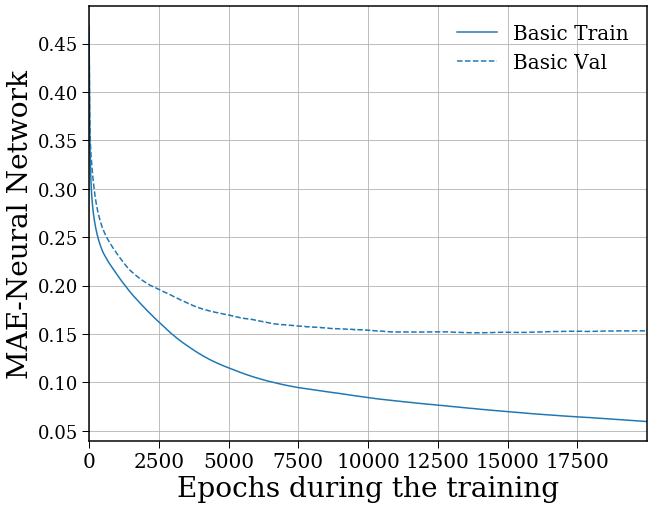

In [33]:
plt.figure(figsize=(10,8))
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 10])
plt.ylabel('MAE-Neural Network')
plt.xlabel('Epochs during the training')

0.16414316320884972 0.2001374732174875 MAR std MAE


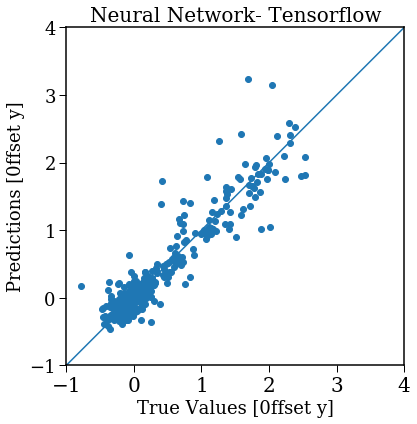

In [34]:
test_predictions_NN = model.predict(normed_test_data).flatten()

error = test_predictions_NN - test_labels
print(np.mean(np.abs(error)),np.std(np.abs(error)), 'MAR std MAE')

plt.figure(figsize=(10,6))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_NN)
plt.xlabel('True Values [0ffset y]',fontsize=18)
plt.title('Neural Network- Tensorflow', fontsize=20)
plt.ylabel('Predictions [0ffset y]',fontsize=18)
lims = [-1, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.tight_layout()
 

0.012192868645578307 Mean error predicted values
0.25855235479159605 Std error predicted values


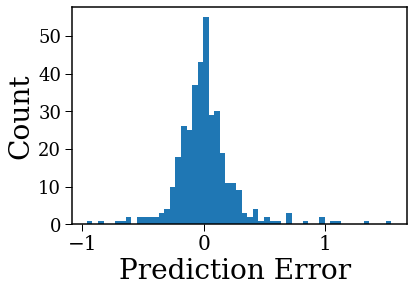

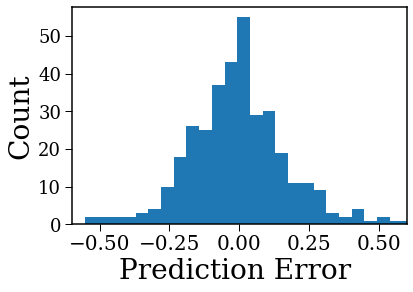

In [35]:
error = test_predictions_NN - test_labels
print(np.mean(error), 'Mean error predicted values')
print(np.std(error), 'Std error predicted values')


plt.hist(error, bins = 55)
plt.xlabel("Prediction Error ")
_ = plt.ylabel("Count")

plt.figure()
plt.hist(error, bins = 55)
plt.xlim(-0.6,0.6)
plt.xlabel("Prediction Error ")
_ = plt.ylabel("Count")


(260, 266)

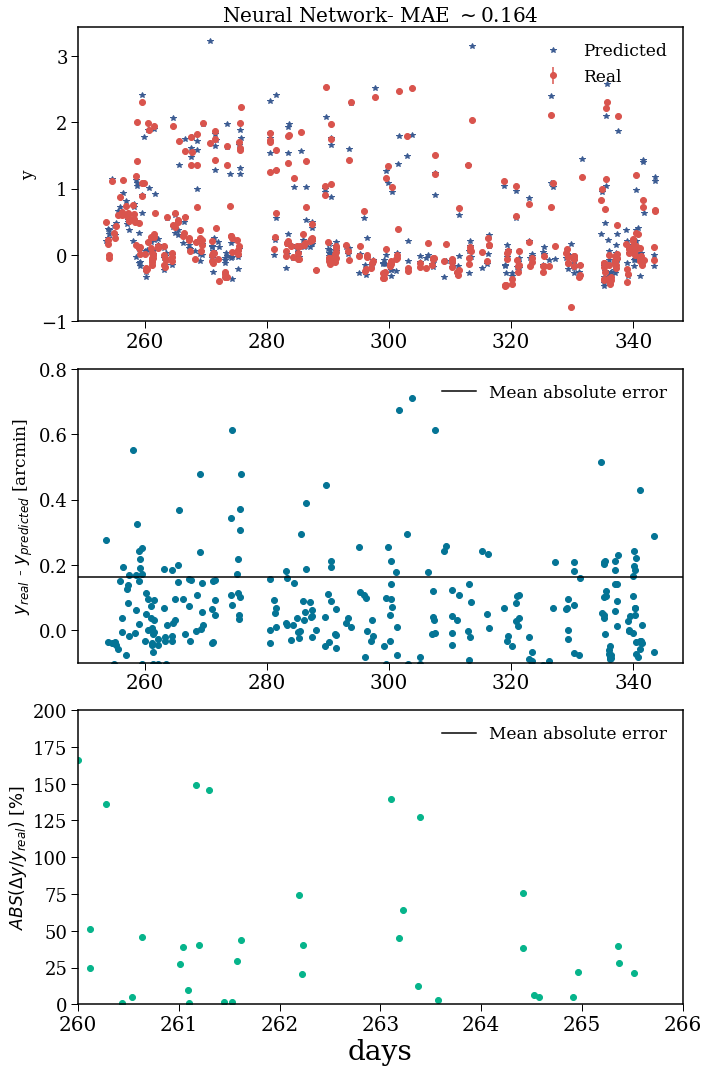

In [36]:
err = (np.mean(np.abs(test_labels-test_predictions_NN)))
# SetPlotStyle()
import seaborn as sns
fig= plt.figure(figsize=(10,15))
plt.subplot(311)
plt.tight_layout()
plt.errorbar(data_time_all[test_dataset.index],  test_labels,yerr=dy_all_data[test_dataset.index],fmt='o',color=sns.xkcd_rgb["pale red"],label='Real')
plt.plot(data_time_all[test_dataset.index], test_predictions_NN,color=sns.xkcd_rgb["denim blue"],marker='*',linestyle = 'None',label='Predicted')
plt.ylabel('y',fontsize=17)
# plt.xlabel('days',fontsize=17)
plt.legend(fontsize=17)
plt.title(r'Neural Network- MAE $\sim$'+format(err, '.3f'), fontsize=20)
plt.tight_layout()#%.2f

 
plt.subplot(312)
plt.plot(data_time_all[test_dataset.index], (test_labels-test_predictions_NN),'o',color=sns.xkcd_rgb["sea blue"])
plt.axhline(np.mean(np.abs(test_labels-test_predictions_NN)),color='k', label='Mean absolute error')
plt.ylabel(r'$y_{real}$ - $y_{predicted}$ [arcmin]',fontsize=17)
plt.legend(fontsize=17)
plt.tight_layout()
plt.ylim(-0.1,0.8)

plt.subplot(313)
plt.plot(data_time_all[test_dataset.index], 100*np.abs((test_labels-test_predictions_NN)/test_labels),'o',color=sns.xkcd_rgb["green blue"])
plt.axhline(100*np.mean(np.abs((test_labels-test_predictions_NN)/test_labels)),color='k', label='Mean absolute error')
plt.ylabel(r'$ABS(\Delta y/y_{real})$ [$\%$]',fontsize=17)
plt.xlabel('days')
plt.legend(fontsize=17)
plt.tight_layout()
plt.ylim(0,200)
plt.xlim(260,266)

 

#  Other algorithms- random forest regressor: 

Random forest validation MAE RANDOM FOREST MODEL =  0.14677187919578158


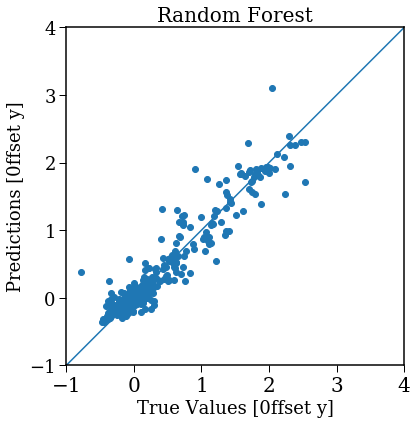

In [37]:
#Try another ML algorithms:  random forest regressor and XGBRegressor
#Random forest model first:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

model_RF = RandomForestRegressor()
model_RF.fit(normed_train_data, train_labels) #Training

# Get the mean absolute error on the validation data
predicted_RF = model_RF.predict(normed_test_data)
MAE_RF = mean_absolute_error(test_labels, predicted_RF)
print('Random forest validation MAE RANDOM FOREST MODEL = ', MAE_RF)



plt.figure(figsize=(10,6))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, predicted_RF)
plt.xlabel('True Values [0ffset y]',fontsize=18)
plt.title('Random Forest', fontsize=20)
plt.ylabel('Predictions [0ffset y]',fontsize=18)
lims = [-1, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.tight_layout()


# Gaussian Process

In [38]:
#The best kernels I found for this dataset are: 
kernels = [RationalQuadratic(length_scale=0.05),ConstantKernel() +Matern(length_scale=0.05)]
# kk = ['Ratquadr','Matern'] 
 

X = normed_train_data#.reshape(-1,1)
y = train_labels
train_dy = dy_all_data[train_dataset.index]


X_test =  np.asarray(normed_test_data)#.reshape(-1,1)

mus_interpol = []
std_interpol = [] 

 
for kernel in kernels:
    gp = GaussianProcessRegressor(kernel=kernel,alpha= np.mean(train_dy**2),n_restarts_optimizer= 1)
    gp.fit(X, y)
    mu, std = gp.predict(X_test, return_std=True)
    print(mu)
    mus_interpol.append(mu)
    std_interpol.append(std)
 
    

[ 2.65296758e-01  1.70825035e-01  3.11395048e-01  1.47831525e-01
  1.37157214e-01  1.02903298e+00  3.06916052e-01  1.79643886e-01
  3.75616802e-01  7.51606137e-01  1.05917083e+00  5.89409118e-01
  6.46436494e-01  9.82364777e-01  7.09807206e-01  3.92258010e-01
  4.88302322e-01  5.48244331e-01  5.55984316e-01  6.11772865e-01
  2.98931287e-01  6.07166993e-01  5.79392041e-01  6.14376913e-01
  1.20422052e+00  3.72019866e-01  1.26605887e+00  1.30979819e+00
  3.40037600e-01  5.74271867e-02 -6.45746192e-02 -5.80737404e-02
  9.49897903e-02  2.33327628e+00  8.04618251e-01  5.63414627e-01
  1.28296901e+00  1.33256554e-01 -1.66362662e-01 -2.35863723e-01
 -2.17991345e-01  2.11475103e-01  1.98149774e+00  1.24705482e+00
  2.06293555e-01 -3.81326351e-02 -6.20089898e-02  2.39649034e-02
  8.13313737e-02 -2.85103550e-02 -5.91268099e-02  9.04910575e-02
 -7.93765732e-02  3.47809939e-02  2.26909617e-01  1.86972591e+00
  1.00966997e-01  8.50546631e-01  1.42220385e-01  9.95286753e-02
  7.89778326e-04 -9.28613

0.14883616112580575 0.23854736946886843


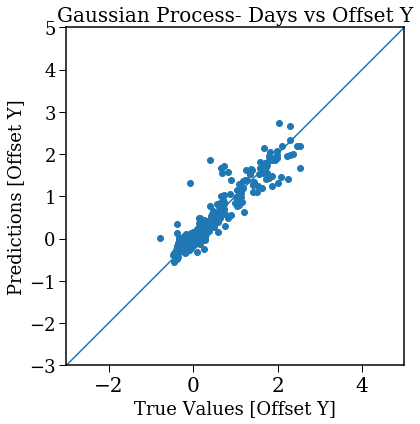

In [39]:
 
plt.figure(figsize=(10,6))
a = plt.axes(aspect='equal')
plt.scatter(test_labels,mus_interpol[0])
plt.xlabel('True Values [Offset Y]',fontsize=18)
plt.title('Gaussian Process- Days vs Offset Y', fontsize=20)
plt.ylabel('Predictions [Offset Y]',fontsize=18)
lims = [-3, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.tight_layout()
 

err_GP = np.float64(test_labels) - mus_interpol[0]
print(np.mean(np.abs(err_GP)), np.std(err_GP)) 

(-0.1, 0.8)

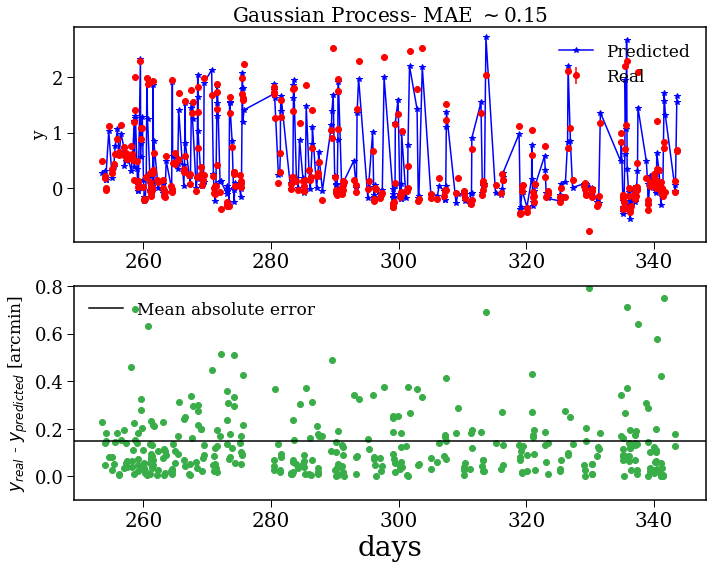

In [40]:
test_dy = dy_all_data[test_dataset.index]
 
errg = np.mean(np.abs(mus_interpol[0]-test_labels))

fig= plt.figure(figsize=(10,8))
plt.subplot(211)
plt.tight_layout()

plt.errorbar(data_time_all[test_dataset.index],test_labels,yerr=test_dy,color= 'r',fmt='o', label='Real')
plt.plot(data_time_all[test_dataset.index],mus_interpol[0],color='b',marker='*',label='Predicted')
plt.ylabel('y',fontsize=17)
plt.legend(fontsize=17)
plt.title(r'Gaussian Process- MAE $\sim$'+format(errg, '.2f'), fontsize=20)
plt.tight_layout()

plt.subplot(212)
plt.plot(data_time_all[test_dataset.index],np.abs(mus_interpol[0]-test_labels),'o',color=sns.xkcd_rgb["medium green"])
plt.axhline(np.mean(np.abs(mus_interpol[0]-test_labels)),color='k', label='Mean absolute error')
plt.ylabel(r'$y_{real}$ - $y_{predicted}$ [arcmin]',fontsize=17)
plt.xlabel('days')
plt.legend(fontsize=17)
plt.tight_layout()
plt.ylim(-0.1,0.8)

